# Group: A-Squared
## Members: Aakash Thatte (12041590) and Amogh Joshi (12040120)

# Comparing different approaches

We will be comparing a few approaches in this notebook. We have done data exploration in a different notebook. Results are present in the report and slides.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Mounted at /content/gdrive


In [ ]:
!pip install torchtext==0.6.0
!pip install pytorch-crf

import math
import time
import gensim
import torch
import torchcrf
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from collections import Counter
from spacy.lang.hi import Hindi
from sklearn.metrics import f1_score, classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.8 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [ ]:
available_gpu = torch.cuda.is_available()
if available_gpu:
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    use_device = torch.device("cuda")
else:
    use_device = torch.device("cpu")

GPU is available: Tesla T4


# Corpus

In [ ]:
class Corpus(object):

    def __init__(self, input_folder, train_file, test_file, min_word_freq, batch_size, wv_file=None):
        # list all the fields
        self.word_field = Field(lower=True)  # [sent len, batch_size]
        self.tag_field = Field(unk_token=None)  # [sent len, batch_size]
        # Character-level input
        self.char_nesting_field = Field(tokenize=list)
        self.char_field = NestedField(self.char_nesting_field)  # [batch_size, sent len, max len char]
        # create dataset using built-in parser from torchtext
        self.train_dataset, self.test_dataset = SequenceTaggingDataset.splits(
            path=input_folder,
            train=train_file,
            validation=None,
            test=test_file,
            fields=(
                (("word", "char"), (self.word_field, self.char_field)),
                ("tag", self.tag_field)
            )
        )
        # convert fields to vocabulary list
        if wv_file:
            self.wv_model = gensim.models.word2vec.Word2Vec.load(wv_file)
            self.embedding_dim = self.wv_model.vector_size
            word_freq = {word: self.wv_model.wv.vocab[word].count for word in self.wv_model.wv.vocab}
            word_counter = Counter(word_freq)
            self.word_field.vocab = Vocab(word_counter, min_freq=min_word_freq)
            vectors = []
            for word, idx in self.word_field.vocab.stoi.items():
                if word in self.wv_model.wv.vocab.keys():
                    vectors.append(torch.as_tensor(self.wv_model.wv[word].tolist()))
                else:
                    vectors.append(torch.zeros(self.embedding_dim))
            self.word_field.vocab.set_vectors(
                stoi=self.word_field.vocab.stoi,
                vectors=vectors,
                dim=self.embedding_dim
            )
        else:
            self.word_field.build_vocab(self.train_dataset.word, min_freq=min_word_freq)
        # build vocab for tag and characters
        self.char_field.build_vocab(self.train_dataset.char)
        self.tag_field.build_vocab(self.train_dataset.tag)
        # create iterator for batch input
        self.train_iter, self.test_iter = BucketIterator.splits(
            datasets=(self.train_dataset, self.test_dataset),
            batch_size=batch_size
        )
        # prepare padding index to be ignored during model training/evaluation
        self.word_pad_idx = self.word_field.vocab.stoi[self.word_field.pad_token]
        self.char_pad_idx = self.char_field.vocab.stoi[self.char_field.pad_token]
        self.tag_pad_idx = self.tag_field.vocab.stoi[self.tag_field.pad_token]

In [ ]:
corpus = Corpus(
    input_folder=f"/content/gdrive/MyDrive/7Semester/bmmnerdataset",
    min_word_freq=3,
    batch_size=128,
    train_file="Bhojpuri_ner.remove[1].train",
    test_file="Bhojpuri_ner.remove[1].test",
)
print(f"Train set: {len(corpus.train_dataset)} sentences")
print(f"Test set: {len(corpus.test_dataset)} sentences")

Train set: 11544 sentences
Test set: 4948 sentences


In [ ]:
magahi_corpus = Corpus(
    input_folder=f"/content/gdrive/MyDrive/7Semester/bmmnerdataset",
    min_word_freq=3,
    batch_size=128,
    train_file="Magahi_ner[1].train",
    test_file="Magahi_ner[1].test",
)
print(f"Train set: {len(magahi_corpus.train_dataset)} sentences")
print(f"Test set: {len(magahi_corpus.test_dataset)} sentences")

Train set: 4255 sentences
Test set: 1065 sentences


In [ ]:
maithili_corpus = Corpus(
    input_folder=f"/content/gdrive/MyDrive/7Semester/bmmnerdataset",
    min_word_freq=3,
    batch_size=128,
    train_file="Maithili_ner[1].train",
    test_file="Maithili_ner[1].test",
)
print(f"Train set: {len(maithili_corpus.train_dataset)} sentences")
print(f"Test set: {len(maithili_corpus.test_dataset)} sentences")

Train set: 7848 sentences
Test set: 1966 sentences


In [ ]:
# def clean(corpus):
#   blanks = []
#   vals = []
#   for i,e in enumerate(corpus.train_dataset.examples):
#       if len(e.word)<=3:
#           blanks.append(i)
#           vals.append(e)
#   for v in vals:
#     corpus.train_dataset.examples.remove(v)
#   print("Cleaned")

In [ ]:
# print(len(corpus.train_dataset.examples))
# clean(corpus)
# print(len(corpus.train_dataset.examples))

11090
Cleaned
10922


# Trainer

We implement the F1 score as a replacement for accuracy function in the Trainer function below. As you can see from the code, we exclude "OTHER" from the calculation and apply `sklearn`'s F1 score function. In this implementation, `average="micro"` reflects the weighted average of F1, as there is different number of words per label in the dataset.

In [ ]:
from tqdm import tqdm
class Trainer(object):

    def __init__(self, model, data, optimizer_cls, device):
        self.device = device
        self.model = model.to(self.device)
        self.data = data
        self.optimizer = optimizer_cls(model.parameters())


    def f1_positive(self, preds, y):
        index_o = self.data.tag_field.vocab.stoi["OTHER"]
        # take all labels except padding and "OTHER"
        positive_labels = [i for i in range(len(self.data.tag_field.vocab.itos))
                           if i not in (self.data.tag_pad_idx, index_o)]
        # make the prediction one dimensional to follow sklearn f1 score input param
        flatten_preds = [pred for sent_pred in preds for pred in sent_pred]
        # remove prediction for padding and "OTHER"
        positive_preds = [pred for pred in flatten_preds
                          if pred not in (self.data.tag_pad_idx, index_o)]
        # make the true tags one dimensional to follow sklearn f1 score input param
        flatten_y = [tag for sent_tag in y for tag in sent_tag]
        # average "micro" means we take weighted average of the class f1 score
        # weighted based on the number of support
        return f1_score(
            y_true=flatten_y,
            y_pred=flatten_preds,
            labels=positive_labels,
            average="micro"
        ) if len(positive_preds) > 0 else 0


    def epoch(self):
        epoch_loss = 0
        true_tags_epoch = []
        pred_tags_epoch = []
        self.model.train()
        for batch in self.data.train_iter:
            # words = [sent len, batch size]
            words = batch.word.to(self.device)
            # chars = [batch size, sent len, char len]
            chars = batch.char.to(self.device)
            # tags = [sent len, batch size]
            true_tags = batch.tag.to(self.device)
            self.optimizer.zero_grad()
            pred_tags_list, batch_loss = self.model(words, chars, true_tags)
            pred_tags_epoch += pred_tags_list
            # to calculate the loss and f1, we flatten true tags
            true_tags_epoch += [
                [tag for tag in sent_tag if tag != self.data.tag_pad_idx]
                for sent_tag in true_tags.permute(1, 0).tolist()
            ]
            batch_loss.backward()
            self.optimizer.step()
            epoch_loss += batch_loss.item()
        epoch_score = self.f1_positive(pred_tags_epoch, true_tags_epoch)
        return epoch_loss / len(self.data.train_iter), epoch_score

    def evaluate(self, iterator, full_report=False):
        epoch_loss = 0
        true_tags_epoch = []
        pred_tags_epoch = []
        self.model.eval()
        with torch.no_grad():
            # similar to epoch() but model is in evaluation mode and no backprop
            for batch in iterator:
                words = batch.word.to(self.device)
                chars = batch.char.to(self.device)
                true_tags = batch.tag.to(self.device)
                pred_tags, batch_loss = self.model(words, chars, true_tags)
                pred_tags_epoch += pred_tags
                true_tags_epoch += [
                    [tag for tag in sent_tag if tag != self.data.tag_pad_idx]
                    for sent_tag in true_tags.permute(1, 0).tolist()
                ]
                epoch_loss += batch_loss.item()
        epoch_score = self.f1_positive(pred_tags_epoch, true_tags_epoch)
        return epoch_loss / len(iterator), epoch_score


    def train(self, n_epochs):
        history = {
            "num_params": self.model.count_parameters(),
            "train_loss": [],
            "train_f1": [],
        }
        elapsed_train_time = 0
        for epoch in tqdm(range(n_epochs)):
            start_time = time.time()
            train_loss, train_f1 = self.epoch()
            end_time = time.time()
            elapsed_train_time += end_time - start_time
            history["train_loss"].append(train_loss)
            history["train_f1"].append(train_f1)
        test_loss, test_f1 = self.evaluate(self.data.test_iter)
        history["test_loss"] = test_loss
        history["test_f1"] = test_f1
        history["elapsed_train_time"] = elapsed_train_time
        return history

    def infer(self, sentence, true_tags=None):
        self.model.eval()
        # tokenize sentence
        nlp = Hindi()
        tokens = [token.text for token in nlp(sentence)]
        max_word_len = max([len(token) for token in tokens])
        # transform to indices based on corpus vocab
        numericalized_tokens = [self.data.word_field.vocab.stoi[token.lower()] for token in tokens]
        numericalized_chars = []
        char_pad_id = self.data.char_pad_idx
        for token in tokens:
            numericalized_chars.append(
                [self.data.char_field.vocab.stoi[char] for char in token]
                + [char_pad_id for _ in range(max_word_len - len(token))]
            )
        # find unknown words
        unk_idx = self.data.word_field.vocab.stoi[self.data.word_field.unk_token]
        unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
        # begin prediction
        token_tensor = torch.as_tensor(numericalized_tokens)
        token_tensor = token_tensor.unsqueeze(-1).to(self.device)
        char_tensor = torch.as_tensor(numericalized_chars)
        char_tensor = char_tensor.unsqueeze(0).to(self.device)
        predictions, _ = self.model(token_tensor, char_tensor)
        # convert results to tags
        predicted_tags = [self.data.tag_field.vocab.itos[t] for t in predictions[0]]
        # print inferred tags
        max_len_token = max([len(token) for token in tokens] + [len('word')])
        max_len_tag = max([len(tag) for tag in predicted_tags] + [len('pred')])
        print(
            f"{'word'.ljust(max_len_token)}\t{'unk'.ljust(max_len_token)}\t{'pred tag'.ljust(max_len_tag)}"
            + ("\ttrue tag" if true_tags else "")
        )
        for i, token in enumerate(tokens):
            is_unk = "✓" if token in unks else ""
            print(
                f"{token.ljust(max_len_token)}\t{is_unk.ljust(max_len_token)}\t{predicted_tags[i].ljust(max_len_tag)}"
                + (f"\t{true_tags[i]}" if true_tags else "")
            )
        return tokens, predicted_tags, unks

# Layers

Implementation of different layers

## Composite Embeddings

Includes usage of pretrained word embedding and char embedding.

In [ ]:
class Embeddings(nn.Module):

    def __init__(self,
                 word_input_dim,
                 word_emb_dim,
                 word_emb_pretrained,
                 word_emb_dropout,
                 word_emb_froze,
                 use_char_emb,
                 char_input_dim,
                 char_emb_dim,
                 char_emb_dropout,
                 char_cnn_filter_num,
                 char_cnn_kernel_size,
                 char_cnn_dropout,
                 word_pad_idx,
                 char_pad_idx,
                 device
                 ):
        super().__init__()
        self.device = device
        self.word_pad_idx = word_pad_idx
        self.char_pad_idx = char_pad_idx
        # Word Embedding
        # initialize embedding with pretrained weights if given
        if word_emb_pretrained is not None:
            self.word_emb = nn.Embedding.from_pretrained(
                embeddings=torch.as_tensor(word_emb_pretrained),
                padding_idx=self.word_pad_idx,
                freeze=word_emb_froze
            )
        else:  # otherwise initialize with random weights
            self.word_emb = nn.Embedding(
                num_embeddings=word_input_dim,
                embedding_dim=word_emb_dim,
                padding_idx=self.word_pad_idx
            )
            self.word_emb.weight.data[self.word_pad_idx] = torch.zeros(word_emb_dim)
        self.word_emb_dropout = nn.Dropout(word_emb_dropout)
        self.output_dim = word_emb_dim
        # Char Embedding
        # this is optional, if use_char_emb is False then we do not use char embedding
        self.use_char_emb = use_char_emb
        if self.use_char_emb:
            self.char_emb_dim = char_emb_dim
            self.char_emb = nn.Embedding(
                num_embeddings=char_input_dim,
                embedding_dim=char_emb_dim,
                padding_idx=char_pad_idx
            )
            # initialize embedding for char padding as zero
            self.char_emb.weight.data[self.char_pad_idx] = torch.zeros(self.char_emb_dim)
            self.char_emb_dropout = nn.Dropout(char_emb_dropout)
            # Char CNN
            self.char_cnn = nn.Conv1d(
                in_channels=char_emb_dim,
                out_channels=char_emb_dim * char_cnn_filter_num,
                kernel_size=char_cnn_kernel_size,
                groups=char_emb_dim,  # different 1d conv for each embedding dim
                ### PADDING
                padding = "same"
            )
            self.char_cnn_dropout = nn.Dropout(char_cnn_dropout)
            self.output_dim += char_emb_dim * char_cnn_filter_num # Here the dimension is changing, so becoming 404 from 256

    def forward(self, words, chars):

        embedding_out = self.word_emb_dropout(self.word_emb(words))
        if not self.use_char_emb: return embedding_out

        char_emb_out = self.char_emb_dropout(self.char_emb(chars))
        batch_size, sent_len, word_len, char_emb_dim = char_emb_out.shape
        char_cnn_max_out = torch.zeros(batch_size, sent_len, self.char_cnn.out_channels, device=self.device)
        for sent_i in range(sent_len):
            # sent_char_emb = [batch size, word length, char emb dim]
            sent_char_emb = char_emb_out[:, sent_i, :, :]
            # sent_char_emb_p = [batch size, char emb dim, word length]
            sent_char_emb_p = sent_char_emb.permute(0, 2, 1)
            # char_cnn_sent_out = [batch size, out channels * char emb dim, word length - kernel size + 1]
            char_cnn_sent_out = self.char_cnn(sent_char_emb_p)
            char_cnn_max_out[:, sent_i, :], _ = torch.max(char_cnn_sent_out, dim=2)
        char_cnn = self.char_cnn_dropout(char_cnn_max_out)
        # concat word and char embedding
        # char_cnn_p = [sentence length, batch size, char emb dim * num filter]
        char_cnn_p = char_cnn.permute(1, 0, 2)
        word_features = torch.cat((embedding_out, char_cnn_p), dim=2)
        return word_features

## LSTM-Attention

Here, the attention layer is optional depending on the `attn_heads` param value.

In [ ]:
class LSTMAttn(nn.Module):

    def __init__(self,
                 input_dim,
                 lstm_hidden_dim,
                 lstm_layers,
                 lstm_dropout,
                 word_pad_idx,
                 attn_heads=None,
                 attn_dropout=None
                 ):
        super().__init__()
        self.word_pad_idx = word_pad_idx
        # bi-lstm layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0
        )
        self.attn_heads = attn_heads
        # attention layer is optional
        if self.attn_heads:
            self.attn = nn.MultiheadAttention(
                embed_dim=lstm_hidden_dim * 2,
                num_heads=attn_heads,
                dropout=attn_dropout
            )

    def forward(self, words, word_features):
        lstm_out, _ = self.lstm(word_features)
        if not self.attn_heads: return lstm_out
        # create masking for paddings
        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out, key_padding_mask=key_padding_mask)
        return attn_out

## Transformer

In [ ]:
# from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # add the positional encoding to the input embeddings
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class Transformer(nn.Module):

    def __init__(self,
                 input_dim,
                 attn_heads,
                 attn_dropout,
                 trf_layers,
                 fc_hidden,
                 word_pad_idx
                 ):
        super().__init__()
        # print(f"Heads - {attn_heads}") # 16
        # print(f"d_model - {input_dim}") # 404
        # print(f"Out dim - {fc_hidden}") # 256
        self.word_pad_idx = word_pad_idx
        self.position_encoder = PositionalEncoding(
            d_model=input_dim
        )
        # REquired :- self.embed_dim = self.head_dim * num_heads
        layers = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=attn_heads,
            activation="relu",
            dropout=attn_dropout
        )
        self.trf = nn.TransformerEncoder(
            encoder_layer=layers,
            num_layers=trf_layers
        )
        # 2-layers fully-connected with GELU activation in-between
        self.fc = nn.Linear(
            in_features=input_dim,
            out_features=fc_hidden
        )
        self.fc_gelu = nn.GELU()
        self.fc_norm = nn.LayerNorm(fc_hidden)
        self.output_dim = fc_hidden

    def forward(self, words, word_features):
        # Transformer
        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        # pos_out = [sentence length, batch size, embedding dim + char emb dim * num filter]
        pos_out = self.position_encoder(word_features)
        # enc_out = [sentence length, batch size, embedding dim + char emb dim * num filter]
        trf_out = self.trf(pos_out, src_key_padding_mask=key_padding_mask)
        # fc_out = [sentence length, batch size, fc hidden]
        fc_out = self.fc_norm(self.fc_gelu(self.fc(trf_out)))
        return fc_out

## CRF

The `init_crf_transitions` can be implemented under the `CRF` class, which is more intuitive.

In [ ]:
class CRF(nn.Module):

    def __init__(self,
                 input_dim,
                 fc_dropout,
                 word_pad_idx,
                 tag_names,
                 ):
        super().__init__()
        self.word_pad_idx = word_pad_idx
        # Fully-connected
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(input_dim, len(tag_names))
        # CRF
        self.crf = torchcrf.CRF(num_tags=len(tag_names))
        self.init_crf_transitions(tag_names)

    def forward(self, words, word_features, tags):
        # fc_out = [sentence length, batch size, output dim]
        fc_out = self.fc(self.fc_dropout(word_features))
        crf_mask = words != self.word_pad_idx
        crf_out = self.crf.decode(fc_out, mask=crf_mask)
        crf_loss = -self.crf(fc_out, tags=tags, mask=crf_mask) if tags is not None else None
        return crf_out, crf_loss

    def init_crf_transitions(self, tag_names, imp_value=-100):
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            # I and L and <pad> impossible as a start
            if tag_name[0] in ("I", "L") or tag_name == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
            # B and I impossible as an end
            if tag_name[0] in ("B", "I"):
                torch.nn.init.constant_(self.crf.end_transitions[i], imp_value)
        # init impossible transitions between positions
        tag_is = {}
        for tag_position in ("B", "I", "O", "U", "L"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        tag_is["P"] = [i for i, tag in enumerate(tag_names) if tag == "tag"]
        impossible_transitions_position = {
            "B": "BOUP",
            "I": "BOUP",
            "O": "IL",
            "U": "IL"
        }
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        # init impossible B and I transitions to different entity types
        impossible_transitions_tags = {
            "B": "IL",
            "I": "IL"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )

# Models



In [ ]:
class NERModel(nn.Module):

    def __init__(self,
                 word_input_dim,
                 word_pad_idx,
                 char_pad_idx,
                 tag_names,
                 device,
                 model_arch="bilstm",
                 word_emb_dim=256,
                 word_emb_pretrained=None,
                 word_emb_dropout=0.5,
                 word_emb_froze=False,
                 use_char_emb=False,
                 char_input_dim=None,
                 char_emb_dim=None,
                 char_emb_dropout=None,
                 char_cnn_filter_num=None,
                 char_cnn_kernel_size=None,
                 char_cnn_dropout=None,
                 lstm_hidden_dim=64,
                 lstm_layers=2,
                 lstm_dropout=0.1,
                 attn_heads=None,
                 attn_dropout=None,
                 trf_layers=None,
                 fc_hidden=None,
                 fc_dropout=0.25
                 ):
        super().__init__()
        # Embeddings
        self.embeddings = Embeddings(
            word_input_dim=word_input_dim,
            word_emb_dim=word_emb_dim,
            word_emb_pretrained=word_emb_pretrained,
            word_emb_dropout=word_emb_dropout,
            word_emb_froze=word_emb_froze,
            use_char_emb=use_char_emb,
            char_input_dim=char_input_dim,
            char_emb_dim=char_emb_dim,
            char_emb_dropout=char_emb_dropout,
            char_cnn_filter_num=char_cnn_filter_num,
            char_cnn_kernel_size=char_cnn_kernel_size,
            char_cnn_dropout=char_cnn_dropout,
            word_pad_idx=word_pad_idx,
            char_pad_idx=char_pad_idx,
            device=device
        )
        # print(f"Embedding out - {self.embeddings.output_dim}")
        if model_arch.lower() == "bilstm":
            # LSTM-Attention
            self.encoder = LSTMAttn(
                 input_dim=self.embeddings.output_dim,
                 lstm_hidden_dim=lstm_hidden_dim,
                 lstm_layers=lstm_layers,
                 lstm_dropout=lstm_dropout,
                 word_pad_idx=word_pad_idx,
                 attn_heads=attn_heads,
                 attn_dropout=attn_dropout
            )
            encoder_output_dim = lstm_hidden_dim * 2
        elif model_arch.lower() == "transformer":
            # Transformer
            self.encoder = Transformer(
                input_dim=self.embeddings.output_dim,
                attn_heads=attn_heads,
                attn_dropout=attn_dropout,
                trf_layers=trf_layers,
                fc_hidden=fc_hidden,
                word_pad_idx=word_pad_idx
            )
            encoder_output_dim = self.encoder.output_dim
        else:
            raise ValueError("param `model_arch` must be either 'bilstm' or 'transformer'")
        # CRF
        self.crf = CRF(
            input_dim=encoder_output_dim,
            fc_dropout=fc_dropout,
            word_pad_idx=word_pad_idx,
            tag_names=tag_names
        )

    def forward(self, words, chars, tags=None):
        word_features = self.embeddings(words, chars)
        # lstm_out = [sentence length, batch size, hidden dim * 2]
        encoder_out = self.encoder(words, word_features)
        # fc_out = [sentence length, batch size, output dim]
        crf_out, crf_loss = self.crf(words, encoder_out, tags)
        return crf_out, crf_loss

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Experiment

## Configurations

In [ ]:
# configurations building block
def get_configs(corpus):
  base = {
      "word_input_dim": len(corpus.word_field.vocab),
      "char_pad_idx": corpus.char_pad_idx,
      "word_pad_idx": corpus.word_pad_idx,
      "tag_names": corpus.tag_field.vocab.itos,
      "device": use_device
  }

  cnn = {
      "use_char_emb": True,
      "char_input_dim": len(corpus.char_field.vocab),
      "char_emb_dim": 37,
      "char_emb_dropout": 0.25,
      "char_cnn_filter_num": 4,
      "char_cnn_kernel_size": 3,
      "char_cnn_dropout": 0.25
  }
  attn = {
      "attn_heads": 4,
      "attn_dropout": 0.25
  }
  transformer = {
      "model_arch": "transformer",
      "trf_layers": 1,
      "fc_hidden": 256,
  }
  # this is the main config, which is based on the previous building blocks
  configs = {
      "bilstm": base,
      "bilstm+cnn": {**base, **cnn},
      "bilstm+cnn+attn": {**base, **cnn, **attn},
      "transformer+cnn": {**base, **transformer, **cnn, **attn}
  }
  return base, cnn, attn, transformer, configs
# base, cnn, attn, transformer, configs = get_configs(corpus)

## Training

Bhojpuri

In [ ]:
num_epochs = 15
histories = {}
for model_name in configs:
    print(f"Start Training: {model_name}")
    trainer = Trainer(
        model=NERModel(**configs[model_name]),
        data=corpus,
        optimizer_cls=Adam,
        device=use_device
    )
    histories[model_name] = trainer.train(num_epochs)
    print(f"Done Training: {model_name}")
    print()

Start Training: bilstm


100%|██████████| 15/15 [03:53<00:00, 15.54s/it]


Done Training: bilstm

Start Training: bilstm+cnn


100%|██████████| 15/15 [04:52<00:00, 19.47s/it]


Done Training: bilstm+cnn

Start Training: bilstm+cnn+attn


100%|██████████| 15/15 [04:48<00:00, 19.25s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Done Training: bilstm+cnn+attn

Start Training: transformer+cnn


100%|██████████| 15/15 [05:24<00:00, 21.64s/it]


Done Training: transformer+cnn



## Results

In [ ]:
max_len_model_name = max([len(m) for m in histories])
print(f"{'MODEL NAME'.ljust(max_len_model_name)}\t{'NUM PARAMS'.ljust(10)}\tTRAINING TIME")
for model_name, history in histories.items():
    print(f"{model_name.ljust(max_len_model_name)}\t{history['num_params']:,}\t{int(history['elapsed_train_time']//60)}m {int(history['elapsed_train_time'] % 60)}s")

MODEL NAME     	NUM PARAMS	TRAINING TIME
bilstm         	1,861,178	3m 53s
bilstm+cnn     	1,941,542	4m 52s
bilstm+cnn+attn	2,007,590	4m 48s
transformer+cnn	4,024,602	5m 24s


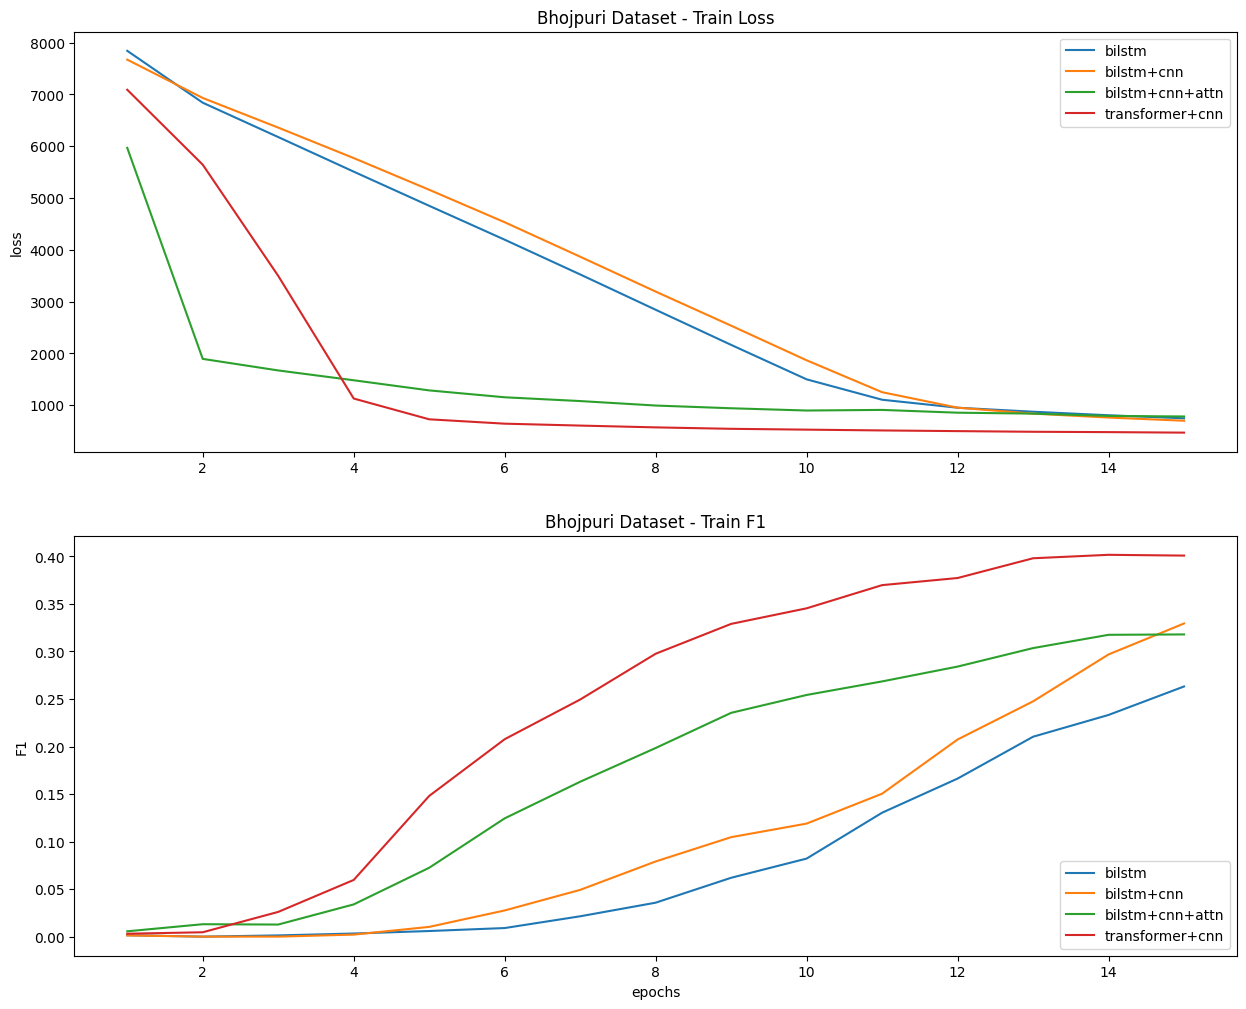

In [ ]:
epochs = [i+1 for i in range(15)]
model_name = "bilstm"
val_loss1 = histories[model_name]["train_loss"]
val_loss2 = histories["bilstm"]["train_loss"]

fig, axs = plt.subplots(2, 1, figsize=(15, 12))
for model_name in histories:
    axs[0].plot(epochs, histories[model_name]["train_loss"], label=model_name)
    axs[1].plot(epochs, histories[model_name]["train_f1"], label=model_name)
_ = axs[0].set_title("Bhojpuri Dataset - Train Loss")
_ = axs[1].set_title("Bhojpuri Dataset - Train F1")
_ = axs[1].set_xlabel("epochs")
_ = axs[0].set_ylabel("loss")
_ = axs[1].set_ylabel("F1")
_ = axs[0].legend(loc="upper right")
_ = axs[1].legend(loc="lower right")

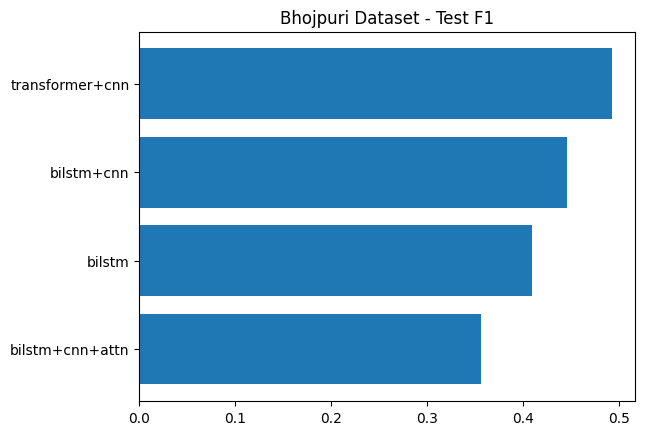

In [ ]:
model_test_f1 = [(m, histories[m]["test_f1"]) for m in histories]
model_test_f1_sorted = sorted(model_test_f1, key=lambda m: m[1])
model_names = [m[0] for m in model_test_f1_sorted]
y_pos = list(range(len(model_names)))
f1_scores = [m[1] for m in model_test_f1_sorted]
fig, ax = plt.subplots()
_ = ax.barh(y_pos, f1_scores, align='center')
_ = ax.set_yticks(y_pos)
_ = ax.set_yticklabels(model_names)
_ = ax.set_title("Bhojpuri Dataset - Test F1")

In [ ]:
model_test_f1

[('bilstm', 0.4094311377245509),
 ('bilstm+cnn', 0.44568998840355617),
 ('bilstm+cnn+attn', 0.3568897227433813),
 ('transformer+cnn', 0.49268292682926823)]

Maithili

In [ ]:
base, cnn, attn, transformer, configs = get_configs(maithili_corpus)

In [ ]:
num_epochs = 15
histories = {}
for model_name in configs:
    print(f"Start Training: {model_name}")
    trainer = Trainer(
        model=NERModel(**configs[model_name]),
        data=maithili_corpus,
        optimizer_cls=Adam,
        device=use_device
    )
    histories[model_name] = trainer.train(num_epochs)
    print(f"Done Training: {model_name}")
    print()

Start Training: bilstm


100%|██████████| 15/15 [03:19<00:00, 13.28s/it]


Done Training: bilstm

Start Training: bilstm+cnn


100%|██████████| 15/15 [04:27<00:00, 17.80s/it]


Done Training: bilstm+cnn

Start Training: bilstm+cnn+attn


100%|██████████| 15/15 [04:28<00:00, 17.93s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Done Training: bilstm+cnn+attn

Start Training: transformer+cnn


100%|██████████| 15/15 [04:59<00:00, 19.96s/it]


Done Training: transformer+cnn



In [ ]:
max_len_model_name = max([len(m) for m in histories])
print(f"{'MODEL NAME'.ljust(max_len_model_name)}\t{'NUM PARAMS'.ljust(10)}\tTRAINING TIME")
for model_name, history in histories.items():
    print(f"{model_name.ljust(max_len_model_name)}\t{history['num_params']:,}\t{int(history['elapsed_train_time']//60)}m {int(history['elapsed_train_time'] % 60)}s")

MODEL NAME     	NUM PARAMS	TRAINING TIME
bilstm         	1,548,750	3m 19s
bilstm+cnn     	1,631,889	4m 26s
bilstm+cnn+attn	1,697,937	4m 28s
transformer+cnn	3,715,333	4m 59s


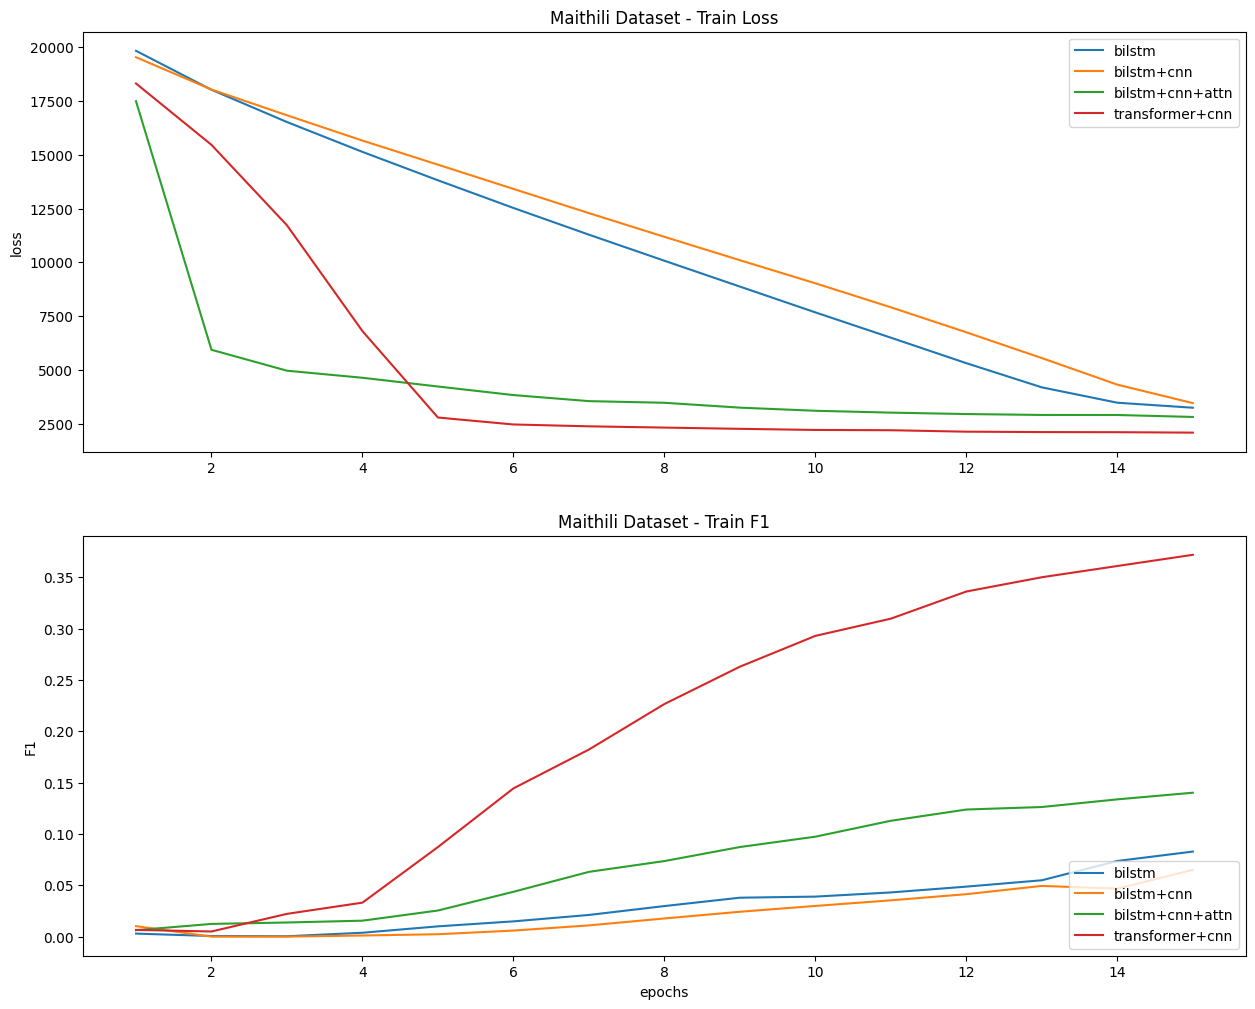

In [ ]:
epochs = [i+1 for i in range(15)]
model_name = "bilstm"
val_loss1 = histories[model_name]["train_loss"]
val_loss2 = histories["bilstm"]["train_loss"]

fig, axs = plt.subplots(2, 1, figsize=(15, 12))
for model_name in histories:
    axs[0].plot(epochs, histories[model_name]["train_loss"], label=model_name)
    axs[1].plot(epochs, histories[model_name]["train_f1"], label=model_name)
_ = axs[0].set_title("Maithili Dataset - Train Loss")
_ = axs[1].set_title("Maithili Dataset - Train F1")
_ = axs[1].set_xlabel("epochs")
_ = axs[0].set_ylabel("loss")
_ = axs[1].set_ylabel("F1")
_ = axs[0].legend(loc="upper right")
_ = axs[1].legend(loc="lower right")

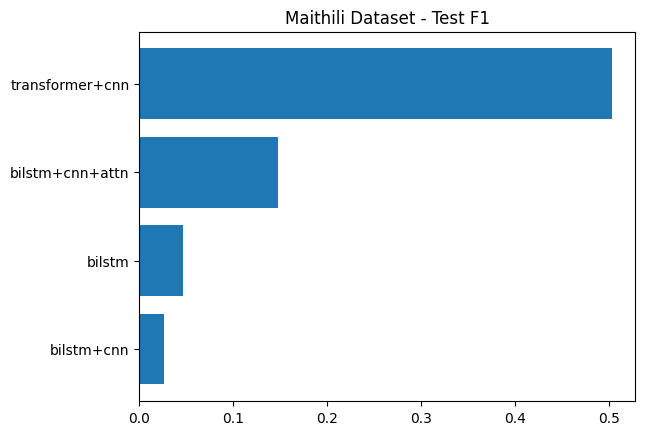

In [ ]:
model_test_f1 = [(m, histories[m]["test_f1"]) for m in histories]
model_test_f1_sorted = sorted(model_test_f1, key=lambda m: m[1])
model_names = [m[0] for m in model_test_f1_sorted]
y_pos = list(range(len(model_names)))
f1_scores = [m[1] for m in model_test_f1_sorted]
fig, ax = plt.subplots()
_ = ax.barh(y_pos, f1_scores, align='center')
_ = ax.set_yticks(y_pos)
_ = ax.set_yticklabels(model_names)
_ = ax.set_title("Maithili Dataset - Test F1")

Magahi

In [ ]:
base, cnn, attn, transformer, configs = get_configs(magahi_corpus)

In [ ]:
num_epochs = 15
histories = {}
for model_name in configs:
    print(f"Start Training: {model_name}")
    trainer = Trainer(
        model=NERModel(**configs[model_name]),
        data=magahi_corpus,
        optimizer_cls=Adam,
        device=use_device
    )
    histories[model_name] = trainer.train(num_epochs)
    print(f"Done Training: {model_name}")
    print()

Start Training: bilstm


100%|██████████| 15/15 [01:03<00:00,  4.21s/it]


Done Training: bilstm

Start Training: bilstm+cnn


100%|██████████| 15/15 [01:18<00:00,  5.26s/it]


Done Training: bilstm+cnn

Start Training: bilstm+cnn+attn


100%|██████████| 15/15 [01:18<00:00,  5.25s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Done Training: bilstm+cnn+attn

Start Training: transformer+cnn


100%|██████████| 15/15 [01:27<00:00,  5.82s/it]


Done Training: transformer+cnn



In [ ]:
max_len_model_name = max([len(m) for m in histories])
print(f"{'MODEL NAME'.ljust(max_len_model_name)}\t{'NUM PARAMS'.ljust(10)}\tTRAINING TIME")
for model_name, history in histories.items():
    print(f"{model_name.ljust(max_len_model_name)}\t{history['num_params']:,}\t{int(history['elapsed_train_time']//60)}m {int(history['elapsed_train_time'] % 60)}s")

MODEL NAME     	NUM PARAMS	TRAINING TIME
bilstm         	887,526	1m 3s
bilstm+cnn     	967,927	1m 18s
bilstm+cnn+attn	1,033,975	1m 18s
transformer+cnn	3,050,475	1m 27s


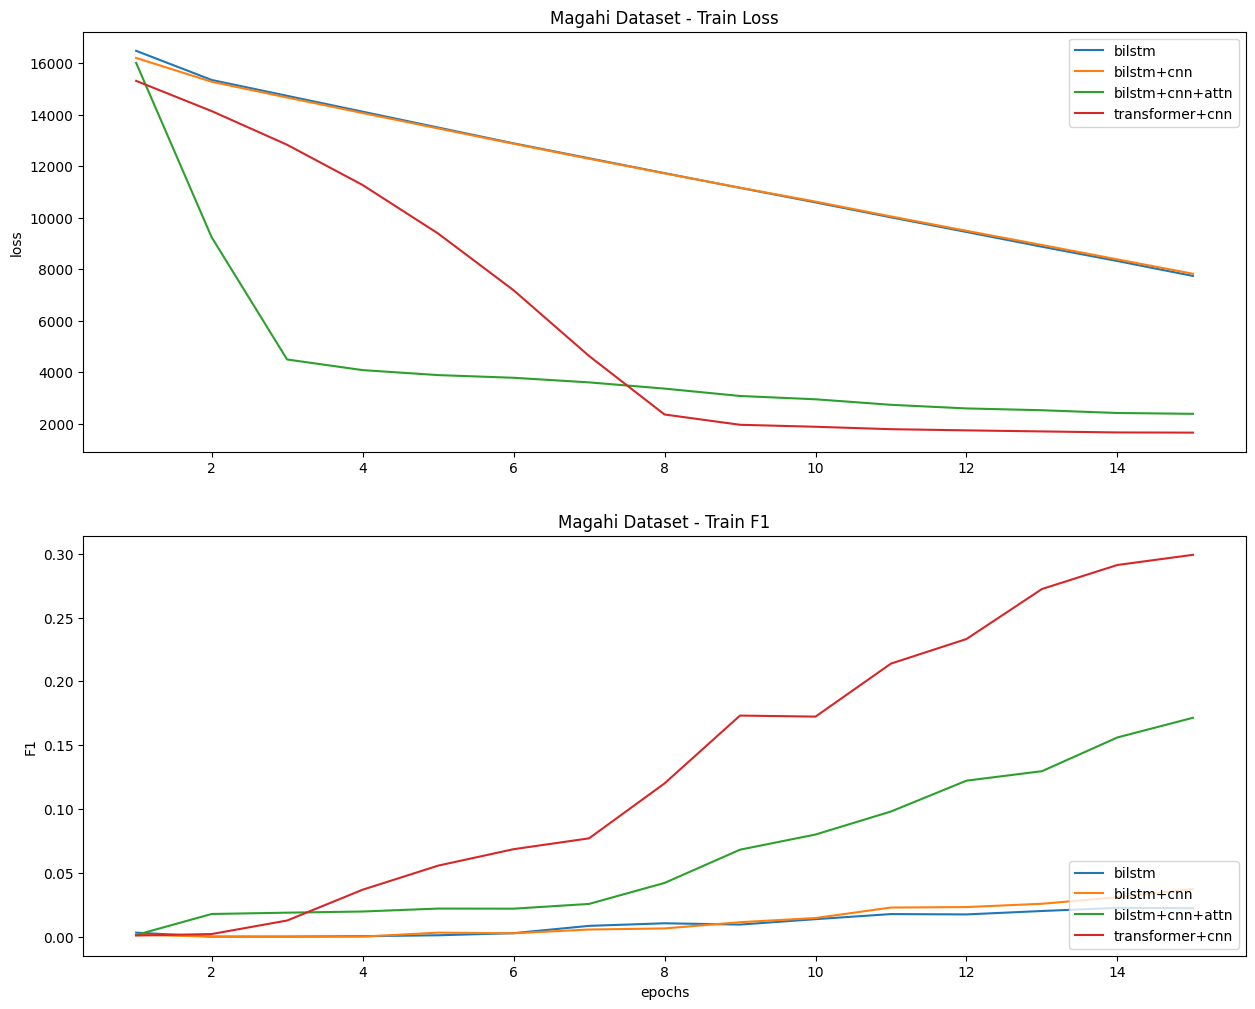

In [ ]:
epochs = [i+1 for i in range(15)]
model_name = "bilstm"
val_loss1 = histories[model_name]["train_loss"]
val_loss2 = histories["bilstm"]["train_loss"]

fig, axs = plt.subplots(2, 1, figsize=(15, 12))
for model_name in histories:
    axs[0].plot(epochs, histories[model_name]["train_loss"], label=model_name)
    axs[1].plot(epochs, histories[model_name]["train_f1"], label=model_name)
_ = axs[0].set_title("Magahi Dataset - Train Loss")
_ = axs[1].set_title("Magahi Dataset - Train F1")
_ = axs[1].set_xlabel("epochs")
_ = axs[0].set_ylabel("loss")
_ = axs[1].set_ylabel("F1")
_ = axs[0].legend(loc="upper right")
_ = axs[1].legend(loc="lower right")

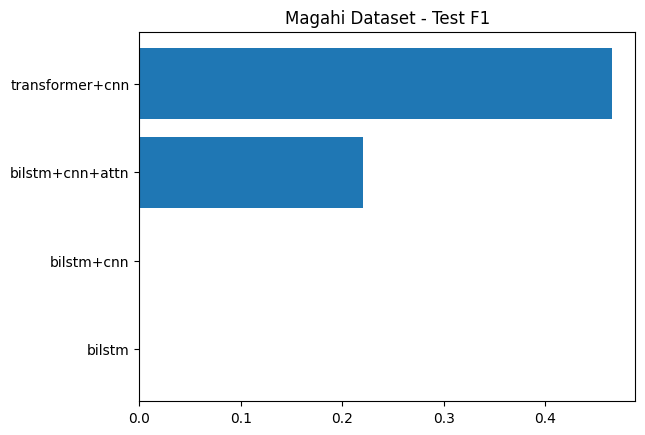

In [ ]:
model_test_f1 = [(m, histories[m]["test_f1"]) for m in histories]
model_test_f1_sorted = sorted(model_test_f1, key=lambda m: m[1])
model_names = [m[0] for m in model_test_f1_sorted]
y_pos = list(range(len(model_names)))
f1_scores = [m[1] for m in model_test_f1_sorted]
fig, ax = plt.subplots()
_ = ax.barh(y_pos, f1_scores, align='center')
_ = ax.set_yticks(y_pos)
_ = ax.set_yticklabels(model_names)
_ = ax.set_title("Magahi Dataset - Test F1")

All data

In [ ]:
all_corpus = Corpus(
    input_folder=f"/content/gdrive/MyDrive/7Semester/bmmnerdataset",
    min_word_freq=3,
    batch_size=128,
    train_file="BMM.train",
    test_file="BMM.test",
)
print(f"Train set: {len(all_corpus.train_dataset)} sentences")
print(f"Test set: {len(all_corpus.test_dataset)} sentences")

Train set: 23647 sentences
Test set: 7979 sentences


In [ ]:
base, cnn, attn, transformer, configs = get_configs(all_corpus)

Only use the best model

In [ ]:
num_epochs = 100
histories = {}
model_name = 'transformer+cnn'
# model_name = "bilstm"
# for model_name in configs:
print(f"Start Training: {model_name}")
trainer = Trainer(
    model=NERModel(**configs[model_name]),
    data=all_corpus,
    optimizer_cls=Adam,
    device=use_device
)
histories[model_name] = trainer.train(num_epochs)
print(f"Done Training: {model_name}")
print()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Start Training: transformer+cnn


100%|██████████| 100/100 [1:21:18<00:00, 48.78s/it]


Done Training: transformer+cnn



In [ ]:
# Saving 100 epoch trained transformer+cnn
import torch
torch.save(trainer.model.state_dict(), "./BMM_100_transformer_cnn.bin")

In [ ]:
num_epochs = 100
model_name = 'bilstm+cnn+attn'
# model_name = "bilstm"
# for model_name in configs:
print(f"Start Training: {model_name}")
trainer = Trainer(
    model=NERModel(**configs[model_name]),
    data=all_corpus,
    optimizer_cls=Adam,
    device=use_device
)
histories[model_name] = trainer.train(num_epochs)
print(f"Done Training: {model_name}")
print()

Start Training: bilstm+cnn+attn


 88%|████████▊ | 88/100 [1:04:29<08:52, 44.38s/it]

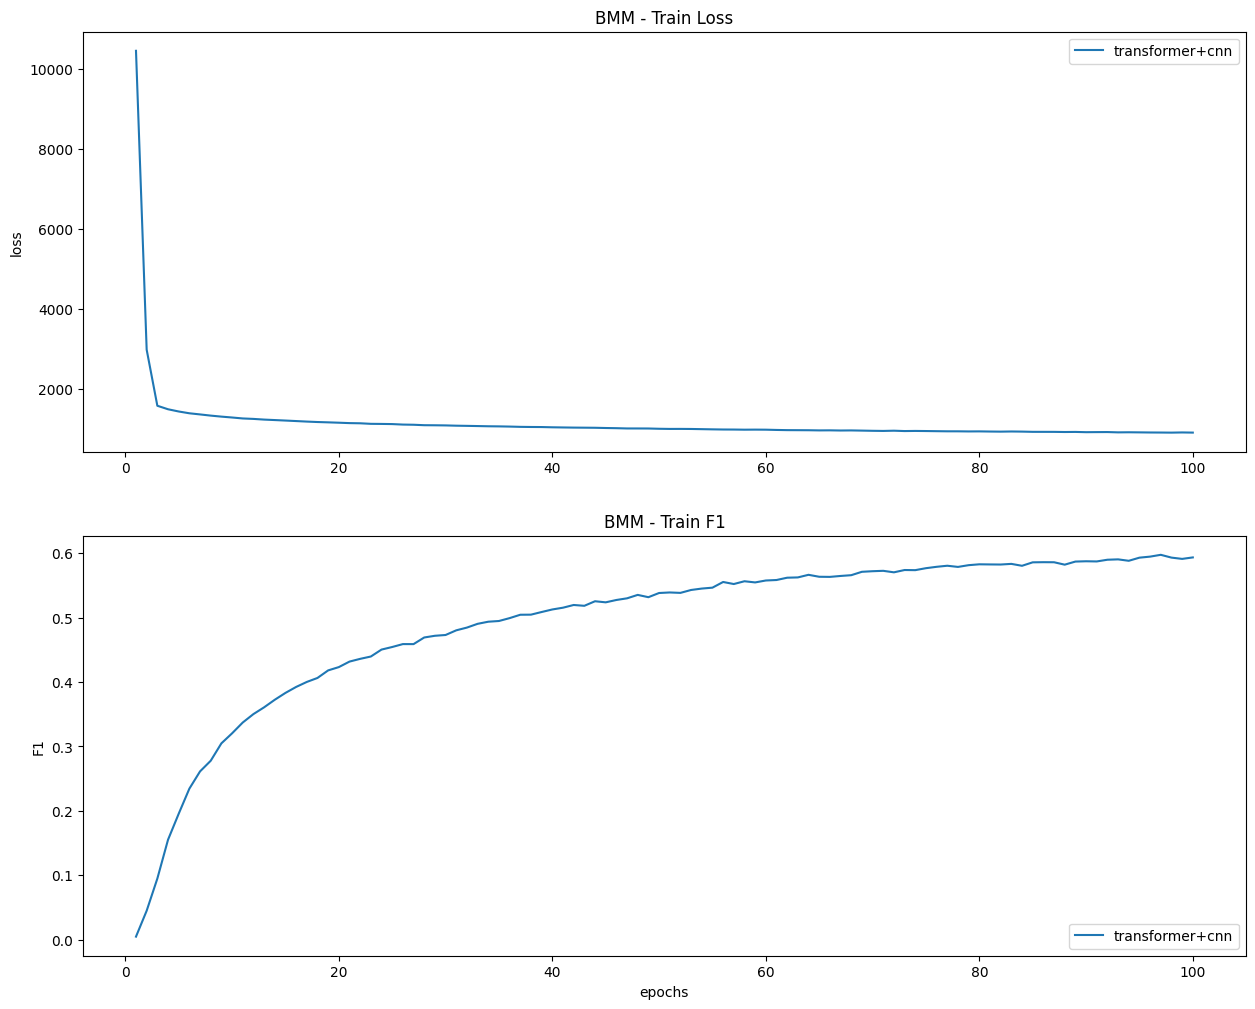

In [ ]:
epochs = [i+1 for i in range(num_epochs)]
# model_name = "bilstm"
# val_loss1 = histories[model_name]["train_loss"]
# val_loss2 = histories["bilstm"]["train_loss"]

fig, axs = plt.subplots(2, 1, figsize=(15, 12))
for model_name in histories:
    axs[0].plot(epochs, histories[model_name]["train_loss"], label=model_name)
    axs[1].plot(epochs, histories[model_name]["train_f1"], label=model_name)
_ = axs[0].set_title("BMM - Train Loss")
_ = axs[1].set_title("BMM - Train F1")
_ = axs[1].set_xlabel("epochs")
_ = axs[0].set_ylabel("loss")
_ = axs[1].set_ylabel("F1")
_ = axs[0].legend(loc="upper right")
_ = axs[1].legend(loc="lower right")

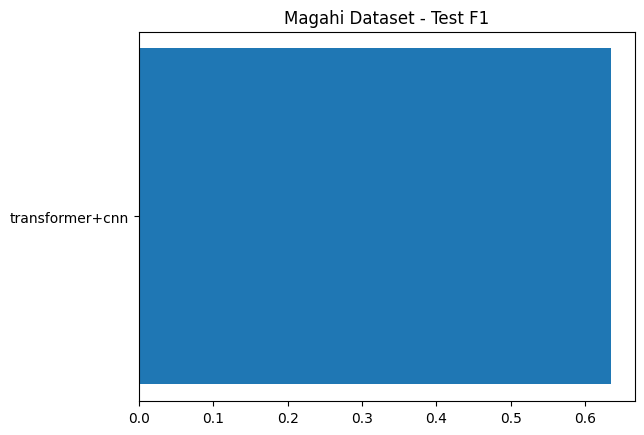

In [ ]:
model_test_f1 = [(m, histories[m]["test_f1"]) for m in histories]
model_test_f1_sorted = sorted(model_test_f1, key=lambda m: m[1])
model_names = [m[0] for m in model_test_f1_sorted]
y_pos = list(range(len(model_names)))
f1_scores = [m[1] for m in model_test_f1_sorted]
fig, ax = plt.subplots()
_ = ax.barh(y_pos, f1_scores, align='center')
_ = ax.set_yticks(y_pos)
_ = ax.set_yticklabels(model_names)
_ = ax.set_title("Magahi Dataset - Test F1")

In [ ]:
import pandas as pd
pd.DataFrame(data=histories)

,transformer+cnn
elapsed_train_time,4878.0733
num_params,5480240
test_f1,0.635338
test_loss,736.248768
train_f1,"[0.004767857662005407, 0.0449636119223103, 0.0..."
train_loss,"[10461.47629856419, 2981.9293938714104, 1579.2..."
